# 1. Introduction


<h2 style="color: white; background-color:#002D62; text-align: center; padding:5px 0px; margin-bottom:0px;">Inventory Analysis and Forecasting</h2>
<p style="text-align: right; font-style:italic; border-bottom:3px #002D62;">By Sreeya Ch</p>

### <h3 style="color: #012169; text-decoration: underline;"> Background </h3>

Any Manufacturing Company is a medium-sized manufacturing company that produces electronic components. They have a wide range of products and maintain an inventory of raw materials, work-in-progress (WIP), and finished goods. The company has been experiencing issues with <u>inventory management</u>, including stockouts, excess inventory, and increased carrying costs. The management team wants to conduct an inventory analysis to identify areas for improvement and optimize their inventory management practices.

---

### <h3 style="color: #012169; text-decoration: underline;"> Objectives: </h3>

The primary objectives of the inventory analysis are as follows:

- Determine the optimal inventory levels for raw materials, WIP, and finished goods.
- Identify opportunities to reduce stockouts and excess inventory.
- Streamline the procurement and production processes to improve efficiency.
- Develop a sustainable inventory management strategy for future growth.

---

### <h3 style="color: #012169; text-decoration: underline;"> Methodology </h3>

- <a href="#DE">Data Exploration</a>

  - <a href="#LD">load data</a>
  - <a href="#EDA">Exploratory Data Analysis</a>

- <a href="#AA">Advance Analysis</a>

  - <a href="#ABCA">ABC Analysis</a>
  - <a href="#EOQA">Economic Order Quantity (EOQ) analysis</a>
  - <a href="#RPA">Reorder Point Analysis</a>
  - <a href="#LTA">Lead Time Analysis</a>


<span id="DE"></span>

# 2. Data Exploration


<span id="LD"></span>

## Load Data


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sales = pd.read_csv("D:/Windows-1/Inventory Project/SalesFINAL12312016.csv", parse_dates=["SalesDate"])
purchase = pd.read_csv("D:/Windows-1/Inventory Project/PurchasesFINAL12312016.csv")
invoice = pd.read_csv("D:/Windows-1/Inventory Project/InvoicePurchases12312016.csv")
end_inv = pd.read_csv("D:/Windows-1/Inventory Project/EndInvFINAL12312016.csv")
beg_inv = pd.read_csv("D:/Windows-1/Inventory Project/BegInvFINAL12312016.csv")
purchase_price = pd.read_csv("D:/Windows-1/Inventory Project/2017PurchasePricesDec.csv")
# Adding a total_sales column
# sales['Total_Sales'] = sales['SalesPrice'] * sales['SalesQuantity']
sales.insert(8, 'TotalSales', sales['SalesPrice'] * sales['SalesQuantity'])


In [28]:
sales.shape

(1048575, 15)

In [29]:
sales.columns

Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity',
       'SalesDollars', 'SalesPrice', 'TotalSales', 'SalesDate', 'Volume',
       'Classification', 'ExciseTax', 'VendorNo', 'VendorName'],
      dtype='object')

<span id="EDA"></span>

## Exploratory Data Analysis


### Inventory Records


In [32]:
display(beg_inv.head())
display(end_inv.head())
nuniques = {"beg_inv": beg_inv.nunique(), "end_inv": end_inv.nunique()}
display(
    pd.DataFrame(nuniques).T[
        [
            "InventoryId",
            "Store",
            "City",
            "Brand",
            "Description",
            "Size",
            "onHand",
            "startDate",
            "endDate",
        ]
    ]
)
print(
    f"beg_inv Brand nunique: {beg_inv.Brand.nunique()}, desc + size nunique: {(beg_inv['Description'] + ' ' + beg_inv['Size']).nunique()}??? Might need cleaning"
)
print(
    f"end_inv Brand nunique: {end_inv.Brand.nunique()}, desc + size nunique: {(end_inv['Description'] + ' ' + end_inv['Size']).nunique()}"
)

InventoryId  Store          City  Brand                  Description  \
0  1_HARDERSFIELD_58      1  HARDERSFIELD     58  Gekkeikan Black & Gold Sake   
1  1_HARDERSFIELD_60      1  HARDERSFIELD     60       Canadian Club 1858 VAP   
2  1_HARDERSFIELD_62      1  HARDERSFIELD     62     Herradura Silver Tequila   
3  1_HARDERSFIELD_63      1  HARDERSFIELD     63   Herradura Reposado Tequila   
4  1_HARDERSFIELD_72      1  HARDERSFIELD     72         No. 3 London Dry Gin   

    Size  onHand  Price   startDate  
0  750mL       8  12.99  2016-01-01  
1  750mL       7  10.99  2016-01-01  
2  750mL       6  36.99  2016-01-01  
3  750mL       3  38.99  2016-01-01  
4  750mL       6  34.99  2016-01-01

InventoryId  Store          City  Brand                  Description  \
0  1_HARDERSFIELD_58      1  HARDERSFIELD     58  Gekkeikan Black & Gold Sake   
1  1_HARDERSFIELD_62      1  HARDERSFIELD     62     Herradura Silver Tequila   
2  1_HARDERSFIELD_63      1  HARDERSFIELD     63   Herradura Reposado Tequila   
3  1_HARDERSFIELD_72      1  HARDERSFIELD     72         No. 3 London Dry Gin   
4  1_HARDERSFIELD_75      1  HARDERSFIELD     75    Three Olives Tomato Vodka   

    Size  onHand  Price     endDate  
0  750mL      11  12.99  2016-12-31  
1  750mL       7  36.99  2016-12-31  
2  750mL       7  38.99  2016-12-31  
3  750mL       4  34.99  2016-12-31  
4  750mL       7  14.99  2016-12-31

InventoryId  Store  City   Brand  Description  Size  onHand  \
beg_inv     206529.0   79.0  67.0  8094.0       7291.0  41.0   474.0   
end_inv     224489.0   80.0  67.0  9653.0       8732.0  47.0   548.0   

         startDate  endDate  
beg_inv        1.0      NaN  
end_inv        NaN      1.0

beg_inv Brand nunique: 8094, desc + size nunique: 8079??? Might need cleaning
end_inv Brand nunique: 9653, desc + size nunique: 9640


In [33]:
beg_inv_brand = beg_inv.loc[:]
beg_inv_brand["Desc_Size"] = beg_inv_brand["Description"] + " " + beg_inv_brand["Size"]
group_desc = (
    beg_inv_brand[["Brand", "Desc_Size"]].groupby("Desc_Size")["Brand"].unique()
)
group_desc.loc[group_desc.apply(len) > 1]

# ? will assume brand is id for Description + Size

Desc_Size
Ch Beauchene Cotes du Rhone 750mL     [43223, 43224]
Ch Bernadotte 10 Haut Medoc 750mL     [19630, 19695]
Ch Brane Cantenac Margaux 11 750mL    [90082, 23290]
Ch Lagrange St Julien 11 GC 750mL     [90025, 23333]
Ch Montrose 10 750mL                  [19972, 36065]
Ch Pesquie Cotes du Ventoux 750mL     [35049, 38471]
Corralejo Reposado Tequila 750mL         [8144, 465]
Dr Frank Johannisberg Rsl 750mL       [37798, 37314]
J Lohr Riverstone Chard 750mL          [6579, 44704]
Jaboulet Cotes du Rhone Par 750mL      [6692, 35977]
Jadot Gevrey Chambertin 13 750mL      [25060, 25056]
Nicole Chanrion Cote de Brou 750mL    [25137, 25140]
Paul Hobbs Beckstoffer Cab S 750mL    [21194, 21737]
Rocca Delle Macie Chianti C 750mL      [6651, 23155]
WhistlePig 10 Yr Old Rye 750mL          [2531, 2208]
Name: Brand, dtype: object

### Demand Data


In [35]:
display(sales.head())
display(
    beg_inv.loc[
        (beg_inv["Brand"] == 1004) & (beg_inv["InventoryId"] == "1_HARDERSFIELD_1004")
    ]
)
# ? Inventory ID = store_city_brand, Brand = description + Size, With Inventory ID we can find how many onhand the inventory have at the beginning and end.
print(sales.Classification.unique())

InventoryId  Store  Brand                 Description        Size  \
0  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
1  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
2  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
3  1_HARDERSFIELD_1004      1   1004  Jim Beam w/2 Rocks Glasses       750mL   
4  1_HARDERSFIELD_1005      1   1005     Maker's Mark Combo Pack  375mL 2 Pk   

   SalesQuantity  SalesDollars  SalesPrice  TotalSales  SalesDate  Volume  \
0              1         16.49       16.49       16.49 2016-01-01     750   
1              2         32.98       16.49       32.98 2016-01-02     750   
2              1         16.49       16.49       16.49 2016-01-03     750   
3              1         14.49       14.49       14.49 2016-01-08     750   
4              2         69.98       34.99       69.98 2016-01-09     375   

   Classification  ExciseTax  VendorNo                   VendorName  
0               1       0.79     12546  JIM BEAM BRANDS COMPANY      
1               1       1.57     12546  JIM BEAM BRANDS COMPANY      
2               1       0.79     12546  JIM BEAM BRANDS COMPANY      
3               1       0.79     12546  JIM BEAM BRANDS COMPANY      
4               1       0.79     12546  JIM BEAM BRANDS COMPANY

InventoryId  Store          City  Brand  \
117  1_HARDERSFIELD_1004      1  HARDERSFIELD   1004   

                    Description   Size  onHand  Price   startDate  
117  Jim Beam w/2 Rocks Glasses  750mL      17  16.49  2016-01-01

[1 2]


From sales and inventory data we can assume that the products the company is selling is liquor. These liquor are then sold to vendors (reseller) so vendors can sell and distribute the products. Excise Tax is tax paid for the transaction so total sales (per transaction) is:

> total_sales = (sales_price\*sales_quantity) - excise_tax


### Lead Time Data


In [38]:
display(purchase.head())
display(invoice.head())
# * assume, lead time = Receiving Date - Purchase Order Date. They did not produce their own goods but buy from vendors.
#  * freight is cargo or shipping cost.

InventoryId  Store  Brand                   Description   Size  \
0    69_MOUNTMEND_8412     69   8412     Tequila Ocho Plata Fresno  750mL   
1     30_CULCHETH_5255     30   5255  TGI Fridays Ultimte Mudslide  1.75L   
2    34_PITMERDEN_5215     34   5215  TGI Fridays Long Island Iced  1.75L   
3  1_HARDERSFIELD_5255      1   5255  TGI Fridays Ultimte Mudslide  1.75L   
4    76_DONCASTER_2034     76   2034     Glendalough Double Barrel  750mL   

   VendorNumber                   VendorName  PONumber      PODate  \
0           105  ALTAMAR BRANDS LLC               8124  2015-12-21   
1          4466  AMERICAN VINTAGE BEVERAGE        8137  2015-12-22   
2          4466  AMERICAN VINTAGE BEVERAGE        8137  2015-12-22   
3          4466  AMERICAN VINTAGE BEVERAGE        8137  2015-12-22   
4           388  ATLANTIC IMPORTING COMPANY       8169  2015-12-24   

  ReceivingDate InvoiceDate     PayDate  PurchasePrice  Quantity  Dollars  \
0    2016-01-02  2016-01-04  2016-02-16          35.71         6   214.26   
1    2016-01-01  2016-01-07  2016-02-21           9.35         4    37.40   
2    2016-01-02  2016-01-07  2016-02-21           9.41         5    47.05   
3    2016-01-01  2016-01-07  2016-02-21           9.35         6    56.10   
4    2016-01-02  2016-01-09  2016-02-16          21.32         5   106.60   

   Classification  
0               1  
1               1  
2               1  
3               1  
4               1

VendorNumber                   VendorName InvoiceDate  PONumber  \
0           105  ALTAMAR BRANDS LLC           2016-01-04      8124   
1          4466  AMERICAN VINTAGE BEVERAGE    2016-01-07      8137   
2           388  ATLANTIC IMPORTING COMPANY   2016-01-09      8169   
3           480  BACARDI USA INC              2016-01-12      8106   
4           516  BANFI PRODUCTS CORP          2016-01-07      8170   

       PODate     PayDate  Quantity    Dollars  Freight Approval  
0  2015-12-21  2016-02-16         6     214.26     3.47      NaN  
1  2015-12-22  2016-02-21        15     140.55     8.57      NaN  
2  2015-12-24  2016-02-16         5     106.60     4.61      NaN  
3  2015-12-20  2016-02-05     10100  137483.78  2935.20      NaN  
4  2015-12-24  2016-02-12      1935   15527.25   429.20      NaN

### Cost Data


In [40]:
display(purchase_price.head())
purchase_price_vendor = purchase_price["VendorName"].unique()

Brand                  Description  Price   Size Volume  Classification  \
0     58  Gekkeikan Black & Gold Sake  12.99  750mL    750               1   
1     62     Herradura Silver Tequila  36.99  750mL    750               1   
2     63   Herradura Reposado Tequila  38.99  750mL    750               1   
3     72         No. 3 London Dry Gin  34.99  750mL    750               1   
4     75    Three Olives Tomato Vodka  14.99  750mL    750               1   

   PurchasePrice  VendorNumber                   VendorName  
0           9.28          8320  SHAW ROSS INT L IMP LTD      
1          28.67          1128  BROWN-FORMAN CORP            
2          30.46          1128  BROWN-FORMAN CORP            
3          26.11          9165  ULTRA BEVERAGE COMPANY LLP   
4          10.94          7245  PROXIMO SPIRITS INC.

<span id="AA"></span>

# 3. Advance Analysis


<span id="DF"></span>

# Demand Forecasting


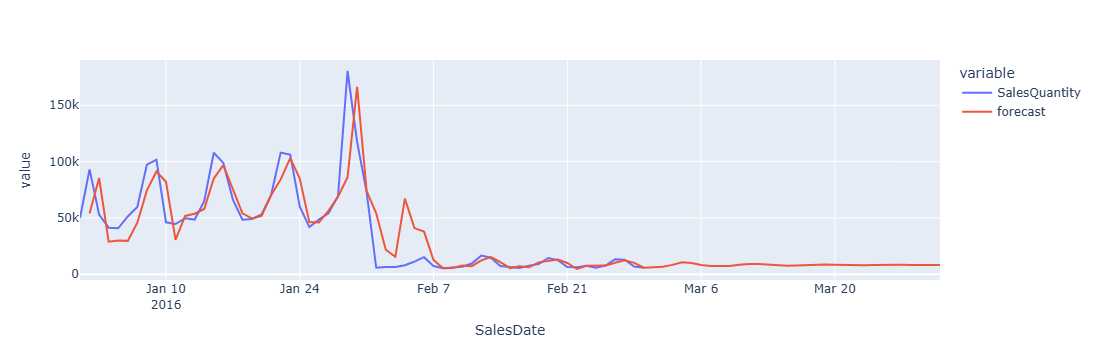


 MAPE: 59.167744410397596
R^2: 0.6958413424511078
SalesDate
2016-02-01    837.824422
2016-02-04    737.133405
2016-02-05    264.263724
dtype: float64
May Forecast Total Demand:  254853.52905420965


In [43]:
from statsmodels.tsa.api import SARIMAX
from IPython.display import clear_output
from math import pow
import plotly.express as px

# * group by date, sum sales quantity to get total sales quantity per day
sales_quantity_price = sales.groupby("SalesDate").agg({"SalesQuantity": "sum"})

# * load ARIMA, Autoregressive Moving Average
mod = SARIMAX(sales_quantity_price,order=(5, 1, 1),type="c")
res = mod.fit()

# * add more dates to sales_quantity_price, predict until 2016-03-31
for i in pd.date_range("2016-03-01", "2016-03-31", freq="D"):
    sales_quantity_price.loc[i, "SalesQuantity"] = None
sales_quantity_price["forecast"] = res.predict(1, 90)

# * plot
clear_output()
px.line(sales_quantity_price, x=sales_quantity_price.index, y=["SalesQuantity","forecast"]).show()


# * calculate MAPE error
absolute_diff = abs(sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"])
relative_diff = absolute_diff / sales_quantity_price["SalesQuantity"] * 100
print("\n MAPE:",relative_diff.dropna().mean())

# * Calculate R2
# Calculate the mean of actual values
mean_actual = sales_quantity_price["SalesQuantity"].mean()

# Calculate the total sum of squares (SST)
sst = ((sales_quantity_price["SalesQuantity"] - mean_actual) ** 2).sum()

# Calculate the residual sum of squares (SSR)
ssr = ((sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"]) ** 2).sum()

# Calculate R^2
r2 = 1 - (ssr / sst)
print(f'R^2: {r2}')

print(relative_diff.sort_values(ascending=False).head(3))

print("May Forecast Total Demand: ",sales_quantity_price.loc["2016-03-01":"2016-03-31", "forecast"].sum())

Demand Forecasting:

We can define the quantity of sales as demand.From the graph there is definitely seasonality factor that affects the price, such as weekly and monthly. 
- We can see that the first peak demand is at January 2nd which is Thursday/Friday and <u>every Thursday/Friday it hits peak and immediately goes down at Sunday.</u> Sunday is company holiday and my educated guess is that vendors restock mostly at Thursday/Friday.
- The peak of demand happens at january 29 (which again is Thursday/Friday) at 180k sales, but approaching february it goes down instantly and only peaked at 16.7k which is only 9%. This indicates that there are monthly seasonality

and let's discuss the forecasting method:
- The time-series method chosen here is autoregressive moving average. The numbers chosen are by random until low error and high R2 score is achieved (done by hand for now, better with hyperparameter tuning).
- The model has MAPE of 59 % and r2 score of 0.7 which is somewhat acceptable considering that the data we have are only until february and we didn't include seasonality (definitely need to be considered) into the models yet.
- The main reason that the error is very high is the monthly change. At February 1st the MAPE shows 800% error which makes perfect sense as the regression model is trying to catch up the huge drop and the error is divided by a really small number (actual value at Feb 1st). And February 4th and 5th next because again it's Thursday and Friday
- Things we can do to improve the model is:
  - Increase the amount of data
  - Seasonal Factor: weekly and monthly, especially monthly since majority of the error lies in the monthly change
> March Forecast quantity: 254853 

<Axes: xlabel='SalesDate'>

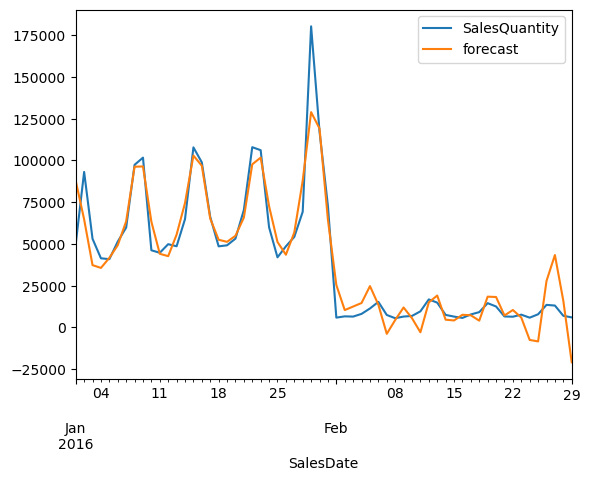

In [45]:

# ? Attempt using seasonality monthly, because there is only 2 month of data and 1 month change, the model interpret this as every month there is change

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression

sales_quantity_price = sales.groupby("SalesDate").agg({"SalesQuantity": "sum"})
sales_quantity_price.index = pd.to_datetime(sales_quantity_price.index)
sales_quantity_price['week'] = sales_quantity_price.index.month
sales_quantity_price['day'] = sales_quantity_price.index.dayofweek

fourierM = CalendarFourier(freq="ME",order=6)

dp = DeterministicProcess(
    index=sales_quantity_price.index,
    constant=True,
    order=4,
    seasonal=True,
    additional_terms=[fourierM],
)

X = dp.in_sample()
model = LinearRegression().fit(X,sales_quantity_price['SalesQuantity'])
y_pred = pd.Series(
  model.predict(X),
  index = X.index,
  name="fitted"
)

sales_quantity_price["forecast"] = y_pred
sales_quantity_price[["SalesQuantity","forecast"]].plot()


<span id="ABCA"> </span>

# ABC Analysis

In [47]:
ABC = (
    sales.groupby("Brand")
    .agg({"SalesQuantity": "sum"})
    .sort_values("SalesQuantity", ascending=False)
)
display(
    "Top 5 Demand",
    ABC.head(),
    "Bottom 5 Demand",
    ABC.tail(),
    "describe data",
    ABC.describe().T,
)
bins = [0, 100, 1000, 30000]
labels = ["C: <100", "B: 100-1k", "A: 1k-30k"]
ABC['bin'] = pd.cut(ABC["SalesQuantity"], bins, labels=labels)

'Top 5 Demand'

SalesQuantity
Brand               
8111           28544
1892           23121
4261           20226
3606           19200
5111           18411

'Bottom 5 Demand'

SalesQuantity
Brand               
17576              1
4308               1
4260               1
4164               1
5114               1

'describe data'

count        mean          std  min   25%   50%    75%  \
SalesQuantity  7658.0  320.079525  1015.017597  1.0  10.0  49.0  238.0   

                   max  
SalesQuantity  28544.0

Text(0, 0.5, 'Frequency')

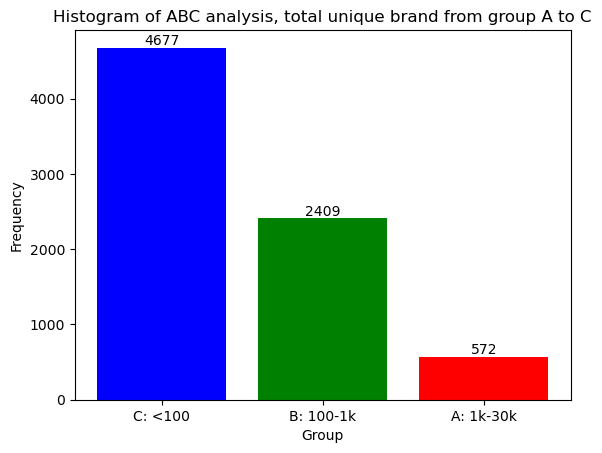

In [48]:
plt.bar(ABC['bin'].value_counts().index, ABC['bin'].value_counts().values, color=['blue','green','red'])
for i, value in enumerate(ABC['bin'].value_counts().values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.title('Histogram of ABC analysis, total unique brand from group A to C')
plt.xlabel('Group')
plt.ylabel('Frequency')

In [49]:
ABC

SalesQuantity        bin
Brand                          
8111           28544  A: 1k-30k
1892           23121  A: 1k-30k
4261           20226  A: 1k-30k
3606           19200  A: 1k-30k
5111           18411  A: 1k-30k
...              ...        ...
17576              1    C: <100
4308               1    C: <100
4260               1    C: <100
4164               1    C: <100
5114               1    C: <100

[7658 rows x 2 columns]

C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\4042626002.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



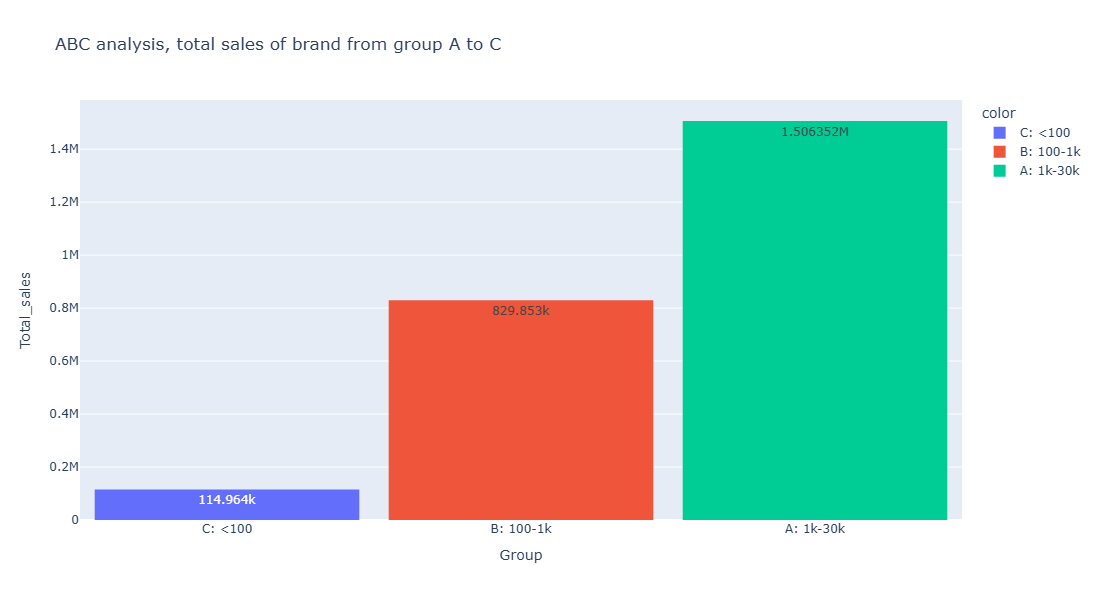

In [50]:
total_group = ABC.groupby('bin').agg({"SalesQuantity":'sum'})['SalesQuantity']
total = px.histogram(total_group.value_counts(), x=total_group.index, y=total_group.values, color=total_group.index, title="ABC analysis, total sales of brand from group A to C",text_auto=True)
total.update_layout(
  width=800,
  height=600,
    xaxis_title='Group',
    yaxis_title='Total_sales',
    bargap=0.1,  # Gap between bars
)
total.show()

In [51]:
total_group

bin
C: <100       114964
B: 100-1k     829853
A: 1k-30k    1506352
Name: SalesQuantity, dtype: int64

# Cummulative ABC Analysis


In [53]:
#Step 1 : Read data from sales Dataframe
# Step 2: Sort the items by Total Sales in descending order
df_sorted = sales.sort_values(by='TotalSales', ascending=False)

# Step 3: Calculate the cumulative sum and cumulative percentage of Total Sales
df_sorted['CumulativeSales'] = df_sorted['TotalSales'].cumsum()
total_sales = df_sorted['TotalSales'].sum()
df_sorted['CumulativePercentage'] = (df_sorted['CumulativeSales'] / total_sales) * 100

# Step 4: Classify the items into A, B, C
def classify(row):
    if row['CumulativePercentage'] <= 80:
        return 'A'
    elif row['CumulativePercentage'] <= 95:
        return 'B'
    else:
        return 'C'

df_sorted['ABC_Class'] = df_sorted.apply(classify, axis=1)

# Step 5: Review the results
df_sorted

InventoryId  Store  Brand                   Description  \
1021958   15_WANBORNE_42188     15  42188  Moet & Chandon Nectar Imp Rs   
736199    69_MOUNTMEND_2753     69   2753    Johnnie Walker Black Label   
818625   73_DONCASTER_42188     73  42188  Moet & Chandon Nectar Imp Rs   
165547    23_ARBINGTON_2492     23   2492  Crown Royal Hand Slct Barrel   
79710      15_WANBORNE_2492     15   2492  Crown Royal Hand Slct Barrel   
...                     ...    ...    ...                           ...   
718000      68_SOLARIS_3730     68   3730  UV Ruby Red Grapefruit Vodka   
236644      31_HORNSEY_5877     31   5877             Ryans Irish Cream   
201596    27_MOUNTMEND_2037     27   2037                Jim Beam Honey   
45838       11_CARDEND_5287     11   5287     Dr McGillicuddy's Vanilla   
582352     6_GOULCREST_5287      6   5287     Dr McGillicuddy's Vanilla   

          Size  SalesQuantity  SalesDollars  SalesPrice  TotalSales  \
1021958  750mL            253      13279.97       52.49    13279.97   
736199   1.75L            124       8678.76       69.99     8678.76   
818625   750mL            151       8303.49       54.99     8303.49   
165547   750mL            131       7203.69       54.99     7203.69   
79710    750mL            129       7093.71       54.99     7093.71   
...        ...            ...           ...         ...         ...   
718000    50mL              1          0.99        0.99        0.99   
236644    50mL              1          0.99        0.99        0.99   
201596    50mL              1          0.99        0.99        0.99   
45838     50mL              1          0.49        0.49        0.49   
582352    50mL              1          0.49        0.49        0.49   

         SalesDate  Volume  Classification  ExciseTax  VendorNo  \
1021958 2016-02-06     750               2      28.46      8112   
736199  2016-01-29    1750               1     227.85      3960   
818625  2016-01-20     750               2      16.99      8112   
165547  2016-01-08     750               1     103.16      3960   
79710   2016-01-08     750               1     101.59      3960   
...            ...     ...             ...        ...       ...   
718000  2016-01-28      50               1       0.05      9206   
236644  2016-01-25      50               1       0.05      8004   
201596  2016-01-30      50               1       0.05     12546   
45838   2016-01-29      50               1       0.05      8004   
582352  2016-01-29      50               1       0.05      8004   

                          VendorName  CumulativeSales  CumulativePercentage  \
1021958  MOET HENNESSY USA INC           1.327997e+04              0.040073   
736199   DIAGEO NORTH AMERICA INC        2.195873e+04              0.066262   
818625   MOET HENNESSY USA INC           3.026222e+04              0.091318   
165547   DIAGEO NORTH AMERICA INC        3.746591e+04              0.113056   
79710    DIAGEO NORTH AMERICA INC        4.455962e+04              0.134461   
...                              ...              ...                   ...   
718000   PHILLIPS PRODUCTS CO.           3.313937e+07             99.999991   
236644   SAZERAC CO INC                  3.313937e+07             99.999994   
201596   JIM BEAM BRANDS COMPANY         3.313937e+07             99.999997   
45838    SAZERAC CO INC                  3.313937e+07             99.999999   
582352   SAZERAC CO INC                  3.313938e+07            100.000000   

        ABC_Class  
1021958         A  
736199          A  
818625          A  
165547          A  
79710           A  
...           ...  
718000          C  
236644          C  
201596          C  
45838           C  
582352          C  

[1048575 rows x 18 columns]

In [54]:
import pandas as pd

# Assuming 'sales' is your DataFrame with 'TotalSales' and 'ABC_Class'

# Step 1: Calculate total sales
C = df_sorted['TotalSales'].sum()
print(f"Total Sales: ${C:,.2f}")

# Step 2: Group by 'ABC_Class' and sum the 'TotalSales' for each category
category_sales = df_sorted.groupby('ABC_Class')['TotalSales'].sum()

# Step 3: Calculate share of sales for each category
category_sales_share = category_sales / C * 100

# Step 4: Display the share of sales by category
print("\nShare of Sales by Category:")
print(category_sales_share)

# Optionally, print in a more readable format
for category, share in category_sales_share.items():
    print(f"Category {category}: {share:,.2f}%")


Total Sales: $33,139,375.29

Share of Sales by Category:
ABC_Class
A    79.999998
B    15.000001
C     5.000000
Name: TotalSales, dtype: float64
Category A: 80.00%
Category B: 15.00%
Category C: 5.00%


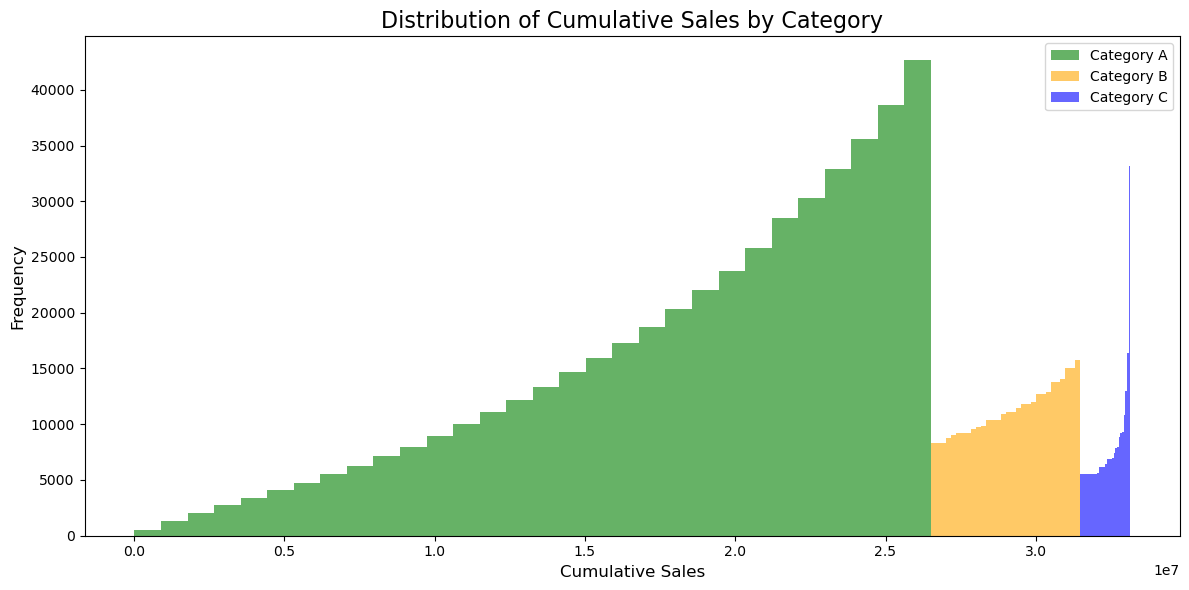

In [55]:
plt.figure(figsize=(12, 6))
plt.hist(df_sorted[df_sorted['ABC_Class'] == 'A']['CumulativeSales'], bins=30, alpha=0.6, label='Category A', color='green')
plt.hist(df_sorted[df_sorted['ABC_Class'] == 'B']['CumulativeSales'], bins=30, alpha=0.6, label='Category B', color='orange')
plt.hist(df_sorted[df_sorted['ABC_Class'] == 'C']['CumulativeSales'], bins=30, alpha=0.6, label='Category C', color='blue')

plt.title('Distribution of Cumulative Sales by Category', fontsize=16)
plt.xlabel('Cumulative Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
C=sales['TotalSales'].sum()
print(f"Total Sales f ${C:,.2f}")

Total Sales f $33,139,375.29


In [57]:
# Total_sales_A=df_sorted[df_sorted['ABC_Class'] == 'A']]
df_a = df_sorted[df_sorted['ABC_Class'] == 'A']
a=df_a['TotalSales'].sum()
# Display the sum of total sales for the top 50 brands
print(f"Total Sales for A Category: ${a:,.2f}")

Total Sales for A Category: $26,511,499.63


In [58]:
df_a = df_sorted[df_sorted['ABC_Class'] == 'B']
a=df_a['TotalSales'].sum()
# Display the sum of total sales for the top 50 brands
print(f"Total Sales for B Category: ${a:,.2f}")

Total Sales for B Category: $4,970,906.79


In [59]:
df_a = df_sorted[df_sorted['ABC_Class'] == 'C']
a=df_a['TotalSales'].sum()
# Display the sum of total sales for the top 50 brands
print(f"Total Sales for C Category: ${a:,.2f}")

Total Sales for C Category: $1,656,968.87


## TOP 50 Brands In A Catergory

In [62]:
import pandas as pd

# Assuming df_sorted is your dataset and you already have ABC classifications in 'ABC_Class' column

# Step 1: Filter items classified as 'A'
df_a = df_sorted[df_sorted['ABC_Class'] == 'A']

# Step 2: Group by 'Brand' and sum the 'TotalSales'
brand_revenue = df_a.groupby('Brand')['TotalSales'].sum()

# Step 3: Sort the results by total sales in descending order to get the top brands
top_brands = brand_revenue.sort_values(ascending=False).head(50)

# Step 4: Calculate the sum of total sales for the top 50 brands
total_sales_top_50 = top_brands.sum()

# Display the top brands by revenue
print(top_brands)

# Display the sum of total sales for the top 50 brands
print(f"Total Sales for Top 50 Brands: ${total_sales_top_50:,.2f}")
# Total_sales_A=df_sorted[df_sorted['ABC_Class'] == 'A']]
# df_a = df_sorted[df_sorted['ABC_Class'] == 'A']
a=df_a['TotalSales'].sum()
share_Top_50= total_sales_top_50/a *100
# Display the sum of total sales for the top 50 brands
print(f"Total Sales for A Category: ${a:,.2f} ")

print(share_Top_50)

Brand
4261     444810.74
3545     357759.17
1233     344712.22
8068     288135.11
3405     275162.97
3858     225014.22
2589     191669.51
4227     178262.91
1376     169922.38
2585     164426.60
8680     162059.53
2757     155678.09
5364     149137.09
3650     140806.71
3876     137778.06
3489     137024.81
3802     135499.93
2120     131853.74
8512     127917.64
3512     119486.31
3102     113732.78
8082     112831.01
2663     112120.16
5138     111334.43
1232     111201.94
8159     110831.36
6570     104220.44
11219    102455.59
8112      96957.71
6650      90134.24
1476      88839.85
3180      88556.37
2114      84619.35
1385      84609.78
6579      82745.53
3423      82265.52
3857      82120.35
3348      79231.88
3826      78946.31
1737      78147.52
5365      76121.75
2432      74896.06
4262      74831.65
2127      74468.51
3893      72377.55
5103      71659.24
3505      69529.29
2753      69525.81
3913      69430.89
42188     69002.22
Name: TotalSales, dtype: float64
Total Sales

In [160]:
import pandas as pd

# Assuming df_sorted is your dataset and you already have ABC classifications in 'ABC_Class' column

# Step 1: Filter items classified as 'A'
df_a = df_sorted[df_sorted['ABC_Class'] == 'A']

# Step 2: Group by 'Brand' and sum the 'TotalSales'
brand_revenue = df_a.groupby('Brand')['TotalSales'].sum()

# Step 3: Sort the results by total sales in descending order to get the top brands
top_brands = brand_revenue.sort_values(ascending=False).head(200)

# Step 4: Calculate the sum of total sales for the top 50 brands
total_sales_top_50 = top_brands.sum()

# Display the top brands by revenue
print(top_brands)

# Display the sum of total sales for the top 50 brands
print(f"Total Sales for Top 200 Brands: ${total_sales_top_50:,.2f}")


Brand
4261     444810.74
3545     357759.17
1233     344712.22
8068     288135.11
3405     275162.97
           ...    
2645      23476.62
4673      23446.65
2492      23425.74
44547     23331.67
1278      23232.37
Name: TotalSales, Length: 200, dtype: float64
Total Sales for Top 200 Brands: $12,138,212.50


C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\1280636287.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




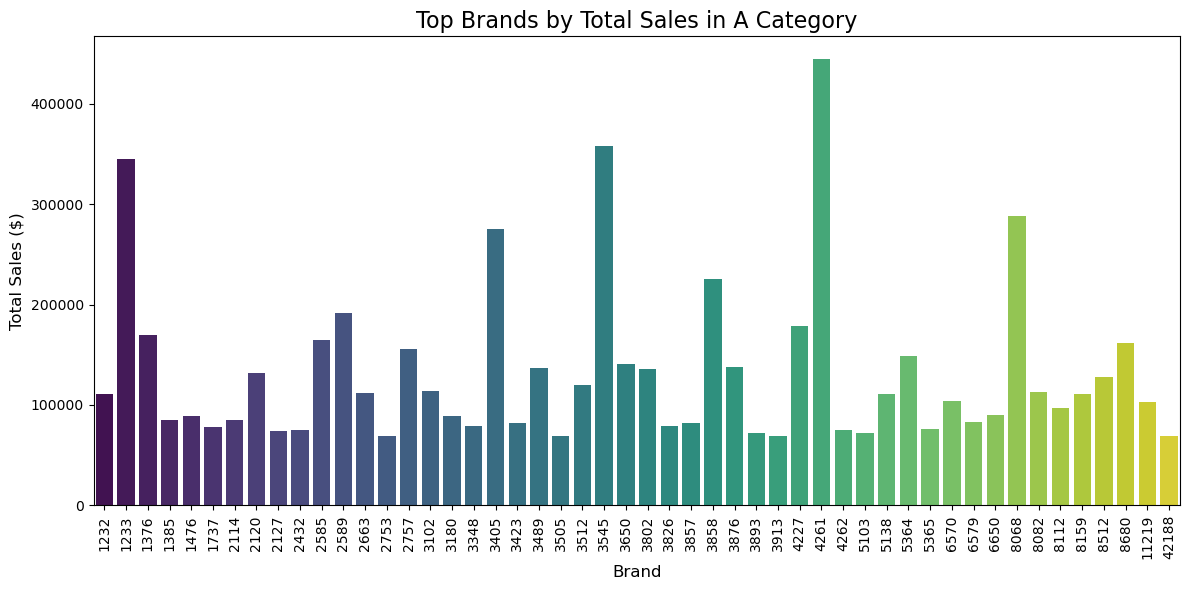

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values, palette='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Top Brands by Total Sales in A Category', fontsize=16)
plt.xlabel('Brand', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

In [157]:
import pandas as pd

# Assuming df_sorted is your dataset and you already have ABC classifications in 'ABC_Class' column

# Step 1: Filter items classified as 'A'
df_a = df_sorted[df_sorted['ABC_Class'] == 'A']

# Step 2: Group by 'Brand' and sum the 'TotalSales'
brand_revenue = df_a.groupby('Brand')['TotalSales'].sum()

# Step 3: Sort the results by total sales in descending order to get the top brands
top_brands = brand_revenue.sort_values(ascending=False).head(100)

# Step 4: Calculate the sum of total sales for the top 50 brands
total_sales_top_100 = top_brands.sum()

# Display the top brands by revenue
print(top_brands)

# Display the sum of total sales for the top 50 brands
print(f"Total Sales for Top 100 Brands: ${total_sales_top_50:,.2f}")


Brand
4261     444810.74
3545     357759.17
1233     344712.22
8068     288135.11
3405     275162.97
           ...    
8202      40253.71
8339      40081.68
3238      39782.88
1180      39767.45
11214     39733.42
Name: TotalSales, Length: 100, dtype: float64
Total Sales for Top 100 Brands: $9,194,316.46


## Sales Performance By store

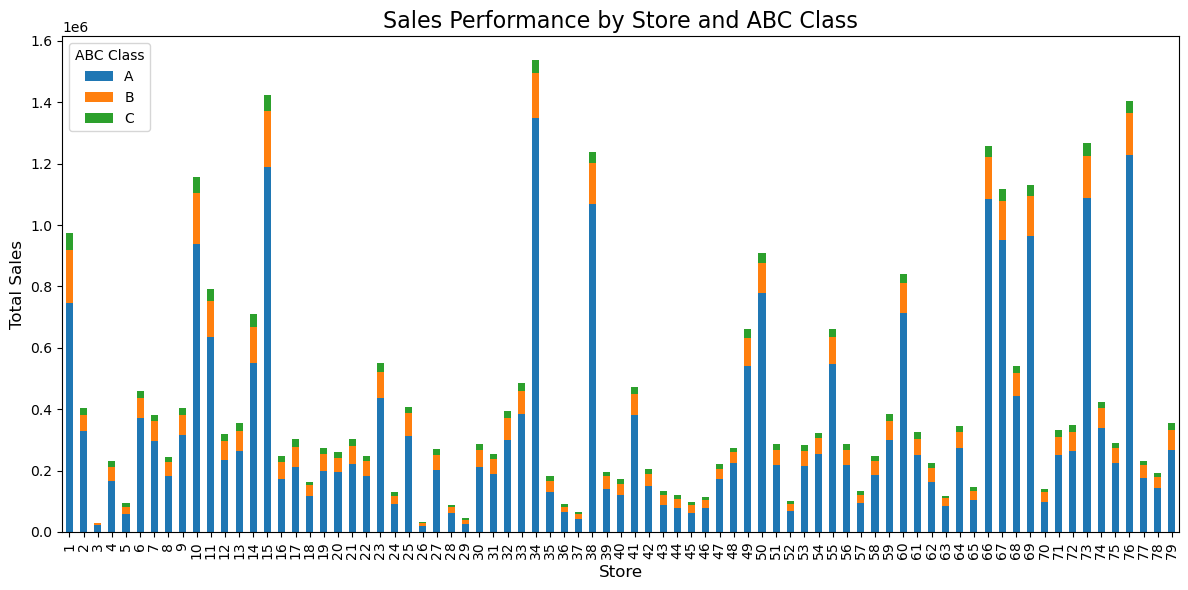

In [66]:
# Group by Store and ABC Class to analyze sales distribution
store_sales = df_sorted.groupby(['Store', 'ABC_Class'])['TotalSales'].sum().unstack().fillna(0)

# Plot Sales Performance by Store
store_sales.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sales Performance by Store and ABC Class', fontsize=16)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(title='ABC Class', loc='upper left')
plt.tight_layout()
plt.show()


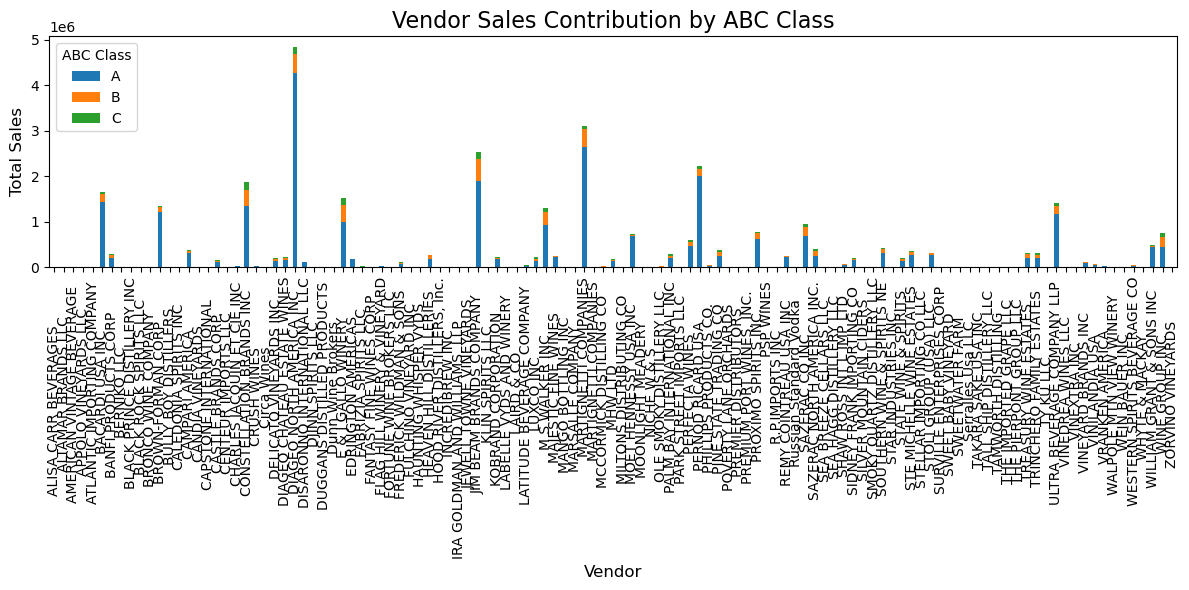

In [67]:
# Group by Vendor and ABC Class to analyze sales contribution
vendor_sales = df_sorted.groupby(['VendorName', 'ABC_Class'])['TotalSales'].sum().unstack().fillna(0)

# Plot Vendor Sales Contribution by ABC Class
vendor_sales.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Vendor Sales Contribution by ABC Class', fontsize=16)
plt.xlabel('Vendor', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(title='ABC Class', loc='upper left')
plt.tight_layout()
plt.show()


ABC Analysis:
- We divided the group into 3 categories based on the sales, A group being group that the company should focus the most since the demand are large, B group is medium moderation, and finally C group that have least moderation.
- We can sort each group based on the sales data, brands that have less than 100 sales in January and February 2016 are put in the C group, 100 to 1000 sales in the B group, and finally 1000 to 30k (max value)
- As we can see the majority of brand is in the C group, 4677 brands and some of them only have 1 sales. B Group has 2409 and C Group has 572.
- C group has a lot of brand and A group is only 12% of C Group. But if we compare the total amount of sales of C group 114k and A group 1.5 mio it is 1300% increase. This means the company should prioritize the A group more in inventory management since there are a lot of demand while C group otherwise.
- Strategy can vary, R&D to increase quality of C or B group and market them better, create better supply chain for A group, etc. 

## Sales Distribution and Insights

### Overall Sales Distribution
- **Category A**: $26,511,499.63  
- **Category B**: $4,970,906.79  
- **Category C**: $1,656,968.87  

### Contribution of Top Brands in Category A
- Top 50 brands contribute **$6,654,862.83**.  
- Top 100 brands contribute **$9,194,316.46**.  
- Top 200 brands contribute **$12,138,212.50**.  

The analysis highlights that the **top 50 brands in Category A account for a significant share of revenue**, emphasizing the importance of regularly stocking these products.

### Next Steps
To strengthen inventory decisions, we will incorporate:
- **Economic Order Quantity (EOQ)**  
- **Safety Stock**  
- **Reorder Level Analysis**

These measures will ensure optimal stocking strategies to maximize revenue and minimize stockouts.



<span id ="EOQA"></span>

# Economic Order Quantity (EOQ Analysis)
![EOQ formula](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.founderjar.com%2Fwp-content%2Fuploads%2F2021%2F07%2FEconomic-Order-Quantity-formula.jpg&f=1&nofb=1&ipt=f5092e8216a6c6e0a1189a7faa763c41bb2984fccafb48a1916ba2f921ceb817&ipo=images)

- Assume I (Holding cost %) to 30% of purchase price
- EOQ only for 2 months

In [70]:
# * Demand 2 month
from math import pow, ceil


demand_jan_feb = (

    sales.groupby("Brand")

    .agg({"SalesQuantity": "sum"})

    .sort_values("SalesQuantity", ascending=False)
)


# * Cost Per Order (CPO), Freight Cost

purchase_invoice = pd.merge(
    left=purchase[["PONumber", "Brand", "Description", "Size", "Quantity"]],
    right=invoice,
    on="PONumber",
    how="right",
)

purchase_invoice_vol = pd.merge(
    left=purchase_invoice,
    right=purchase_price[["Brand", "Volume"]],
    on="Brand",
    how="left",
)
purchase_invoice_vol["vol_quantity"] = purchase_invoice_vol["Quantity_x"].astype(
    "float"
) * purchase_invoice_vol["Volume"].astype("float")
purchase_invoice_vol.set_index("PONumber", inplace=True)
purchase_invoice_vol["vol_quantity_total"] = purchase_invoice_vol.groupby(
    "PONumber"
).agg({"vol_quantity": "sum"})
purchase_invoice_vol["CPO"] = (
    purchase_invoice_vol["vol_quantity"]
    / purchase_invoice_vol["vol_quantity_total"]
    * purchase_invoice_vol["Freight"]
)

CPO = purchase_invoice_vol.groupby("Brand").agg({"CPO": "mean"})

# * Cost Per Unit (C), Holding Cost (%) assume holding cost = 30%, Holding Cost ($) = I*C = I*0.3
C = purchase_price[["Brand", "PurchasePrice"]].set_index("Brand")
H = C * 0.3

# * Combine to Brand
EOQ = demand_jan_feb.copy()
EOQ["CPO"] = CPO
EOQ["H"] = H

# * Calculate and dropna
EOQ["EOQ"] = 2 * EOQ["SalesQuantity"] * EOQ["CPO"] / EOQ["H"]
EOQ["EOQ"] = EOQ["EOQ"].apply(lambda x: ceil(pow(x, 0.5)) if pd.notna(x) else 0)
EOQ.dropna(inplace=True)
EOQ["Volume"] = purchase_price[["Brand", "Volume"]].set_index("Brand")
df_sorted['EOQ']=EOQ['EOQ']
EOQ['ABC']=df_sorted['ABC_Class']
display(EOQ.head(15), EOQ.describe(),EOQ.groupby("ABC").agg({"EOQ":"mean"}).T)


SalesQuantity       CPO      H  EOQ Volume ABC
Brand                                                
8111           28544  0.275602  0.231  261     50   A
1892           23121  0.275172  0.216  243     50   C
4261           20226  2.521666  4.851  146   1750   B
3606           19200  0.282331  0.222  221     50   A
5111           18411  0.190702  0.216  181     50   A
3837           14057  0.354569  0.216  215     50   C
4135           12477  0.286572  0.234  175     50   C
4157           12102  0.283627  0.216  179     50   C
3545           11883  2.009732  6.567   86   1750   B
8068           11189  2.749199  5.472  107   1750   A
5491           11027  0.275882  0.438  118     50   B
3609           10355  0.291820  0.222  165     50   A
4227           10209  4.480661  4.251  147   1750   C
1233            9578  2.431534  7.881   77   1750   B
3858            9378  1.522975  5.331   74    750   B

SalesQuantity          CPO            H          EOQ
count    7146.000000  7146.000000  7146.000000  7146.000000
mean      342.467534     1.009330     5.314242     8.939267
std      1047.176109     6.140746    12.029077    13.994639
min         1.000000     0.000154     0.114000     1.000000
25%        12.000000     0.255775     2.025000     2.000000
50%        61.000000     0.405236     3.045000     5.000000
75%       270.000000     0.624410     5.355000    11.000000
max     28544.000000   203.315455   687.021000   261.000000

ABC         A         B       C
EOQ  8.699091  9.294387  8.8966

C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\938212328.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




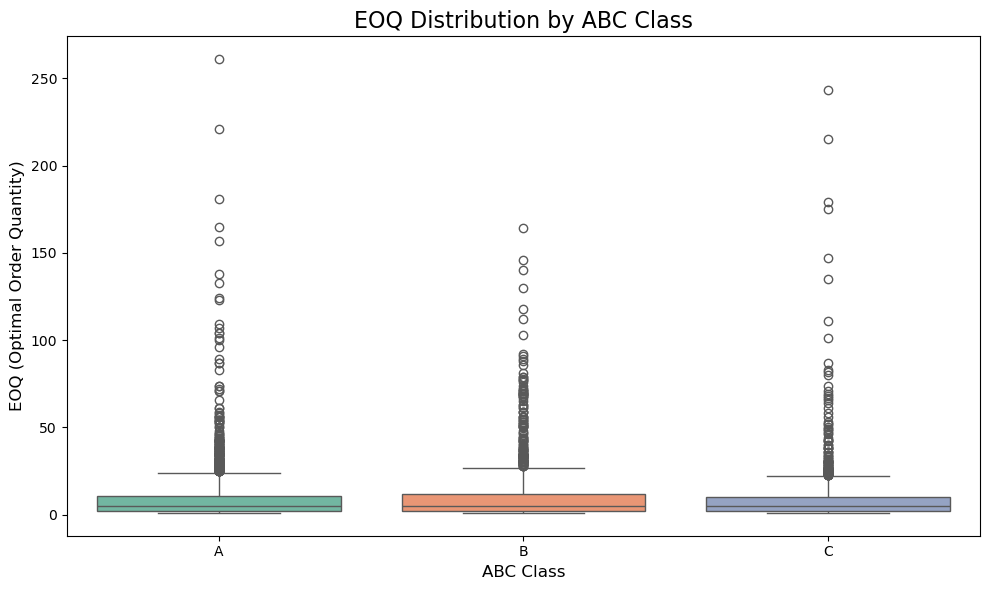

In [71]:
# Visualization of EOQ by ABC Class
plt.figure(figsize=(10, 6))
sns.boxplot(x='ABC_Class', y='EOQ', data=df_sorted, palette='Set2')
plt.title('EOQ Distribution by ABC Class', fontsize=16)
plt.xlabel('ABC Class', fontsize=12)
plt.ylabel('EOQ (Optimal Order Quantity)', fontsize=12)
plt.tight_layout()
plt.show()


In [72]:
import pandas as pd
import numpy as np

# Assuming EOQ DataFrame has columns 'EOQ' and 'ABC'

# Step 1: Define a function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Step 2: Analyze outliers for each ABC class
outliers_by_class = {}
for abc_class in ['A', 'B', 'C']:
    class_data = df_sorted[df_sorted['ABC_Class'] == abc_class]
    outliers, lower, upper = detect_outliers_iqr(class_data, 'EOQ')
    # df_sorted['EOQ']=EOQ['EOQ']
    # Store results
    outliers_by_class[abc_class] = {
        "outliers": outliers,
        "lower_bound": lower,
        "upper_bound": upper,
        "count_outliers": len(outliers)
    }

# Step 3: Print summary for each class
for abc_class, results in outliers_by_class.items():
    print(f"ABC Class {abc_class}:")
    print(f"- Lower Bound: {results['lower_bound']:.2f}")
    print(f"- Upper Bound: {results['upper_bound']:.2f}")
    print(f"- Number of Outliers: {results['count_outliers']}")
    print("- Sample Outliers:")
    print(results['outliers'].head(), "\n")


ABC Class A:
- Lower Bound: -11.50
- Upper Bound: 24.50
- Number of Outliers: 212
- Sample Outliers:
                InventoryId  Store  Brand                   Description  \
22566       10_HORNSEY_2889     10   2889  Buchanans Deluxe 12Yr Scotch   
21784       10_HORNSEY_2585     10   2585         Jameson Irish Whiskey   
3062   1_HARDERSFIELD_19036      1  19036     Nicholson Ranch Est Chard   
5111    1_HARDERSFIELD_2585      1   2585         Jameson Irish Whiskey   
3684    1_HARDERSFIELD_2120      1   2120                 Canadian Club   

        Size  SalesQuantity  SalesDollars  SalesPrice  TotalSales  SalesDate  \
22566  750mL             14        461.86       32.99      461.86 2016-01-15   
21784  750mL             17        407.83       23.99      407.83 2016-01-22   
3062   750mL             24        359.76       14.99      359.76 2016-01-13   
5111   750mL             11        263.89       23.99      263.89 2016-01-29   
3684   1.75L             15        239.85       

In [73]:
eoq_stats = EOQ.groupby('ABC')['EOQ'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
print(eoq_stats)


  ABC      mean        std  min  max  count
0   A  8.699091  13.587079    1  261   3300
1   B  9.294387  13.406383    1  164   2405
2   C  8.896600  15.761979    1  243   1441


In [74]:
# * Demand 2 month
from math import pow, ceil


demand_jan_feb = (

    sales.groupby("Brand")

    .agg({"SalesQuantity": "sum"})

    .sort_values("SalesQuantity", ascending=False)
)


# * Cost Per Order (CPO), Freight Cost

purchase_invoice = pd.merge(
    left=purchase[["PONumber", "Brand", "Description", "Size", "Quantity"]],
    right=invoice,
    on="PONumber",
    how="right",
)

purchase_invoice_vol = pd.merge(
    left=purchase_invoice,
    right=purchase_price[["Brand", "Volume"]],
    on="Brand",
    how="left",
)
purchase_invoice_vol["vol_quantity"] = purchase_invoice_vol["Quantity_x"].astype(
    "float"
) * purchase_invoice_vol["Volume"].astype("float")
purchase_invoice_vol.set_index("PONumber", inplace=True)
purchase_invoice_vol["vol_quantity_total"] = purchase_invoice_vol.groupby(
    "PONumber"
).agg({"vol_quantity": "sum"})
purchase_invoice_vol["CPO"] = (
    purchase_invoice_vol["vol_quantity"]
    / purchase_invoice_vol["vol_quantity_total"]
    * purchase_invoice_vol["Freight"]
)

CPO = purchase_invoice_vol.groupby("Brand").agg({"CPO": "mean"})

# * Cost Per Unit (C), Holding Cost (%) assume holding cost = 30%, Holding Cost ($) = I*C = I*0.3
C = purchase_price[["Brand", "PurchasePrice"]].set_index("Brand")
H = C * 0.3

# * Combine to Brand
EOQ = demand_jan_feb.copy()
EOQ["CPO"] = CPO
EOQ["H"] = H

# * Calculate and dropna
EOQ["EOQ"] = 2 * EOQ["SalesQuantity"] * EOQ["CPO"] / EOQ["H"]
EOQ["EOQ"] = EOQ["EOQ"].apply(lambda x: ceil(pow(x, 0.5)) if pd.notna(x) else 0)
EOQ.dropna(inplace=True)
EOQ["Volume"] = purchase_price[["Brand", "Volume"]].set_index("Brand")
EOQ['ABC']=ABC['bin']
display(EOQ.head(15), EOQ.describe(),EOQ.groupby("ABC").agg({"EOQ":"mean"}).T)

C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\1189272403.py:60: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



SalesQuantity       CPO      H  EOQ Volume        ABC
Brand                                                       
8111           28544  0.275602  0.231  261     50  A: 1k-30k
1892           23121  0.275172  0.216  243     50  A: 1k-30k
4261           20226  2.521666  4.851  146   1750  A: 1k-30k
3606           19200  0.282331  0.222  221     50  A: 1k-30k
5111           18411  0.190702  0.216  181     50  A: 1k-30k
3837           14057  0.354569  0.216  215     50  A: 1k-30k
4135           12477  0.286572  0.234  175     50  A: 1k-30k
4157           12102  0.283627  0.216  179     50  A: 1k-30k
3545           11883  2.009732  6.567   86   1750  A: 1k-30k
8068           11189  2.749199  5.472  107   1750  A: 1k-30k
5491           11027  0.275882  0.438  118     50  A: 1k-30k
3609           10355  0.291820  0.222  165     50  A: 1k-30k
4227           10209  4.480661  4.251  147   1750  A: 1k-30k
1233            9578  2.431534  7.881   77   1750  A: 1k-30k
3858            9378  1.522975  5.331   74    750  A: 1k-30k

SalesQuantity          CPO            H          EOQ
count    7146.000000  7146.000000  7146.000000  7146.000000
mean      342.467534     1.009330     5.314242     8.939267
std      1047.176109     6.140746    12.029077    13.994639
min         1.000000     0.000154     0.114000     1.000000
25%        12.000000     0.255775     2.025000     2.000000
50%        61.000000     0.405236     3.045000     5.000000
75%       270.000000     0.624410     5.355000    11.000000
max     28544.000000   203.315455   687.021000   261.000000

ABC   C: <100  B: 100-1k  A: 1k-30k
EOQ  3.274298  11.538845  39.269231

In [75]:
import pandas as pd
import numpy as np

# Assuming EOQ DataFrame has columns 'EOQ' and 'ABC'

# Step 1: Define a function to detect outliers using IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = data[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Step 2: Analyze outliers for each ABC class
outliers_by_class = {}
for abc_class in ['A', 'B', 'C']:
    class_data = EOQ[EOQ['ABC'] == abc_class]
    outliers, lower, upper = detect_outliers_iqr(class_data, 'EOQ')
    
    # Store results
    outliers_by_class[abc_class] = {
        "outliers": outliers,
        "lower_bound": lower,
        "upper_bound": upper,
        "count_outliers": len(outliers)
    }

# Step 3: Print summary for each class
for abc_class, results in outliers_by_class.items():
    print(f"ABC Class {abc_class}:")
    print(f"- Lower Bound: {results['lower_bound']:.2f}")
    print(f"- Upper Bound: {results['upper_bound']:.2f}")
    print(f"- Number of Outliers: {results['count_outliers']}")
    print("- Sample Outliers:")
    print(results['outliers'].head(), "\n")


ABC Class A:
- Lower Bound: nan
- Upper Bound: nan
- Number of Outliers: 0
- Sample Outliers:
Empty DataFrame
Columns: [SalesQuantity, CPO, H, EOQ, Volume, ABC]
Index: [] 

ABC Class B:
- Lower Bound: nan
- Upper Bound: nan
- Number of Outliers: 0
- Sample Outliers:
Empty DataFrame
Columns: [SalesQuantity, CPO, H, EOQ, Volume, ABC]
Index: [] 

ABC Class C:
- Lower Bound: nan
- Upper Bound: nan
- Number of Outliers: 0
- Sample Outliers:
Empty DataFrame
Columns: [SalesQuantity, CPO, H, EOQ, Volume, ABC]
Index: [] 



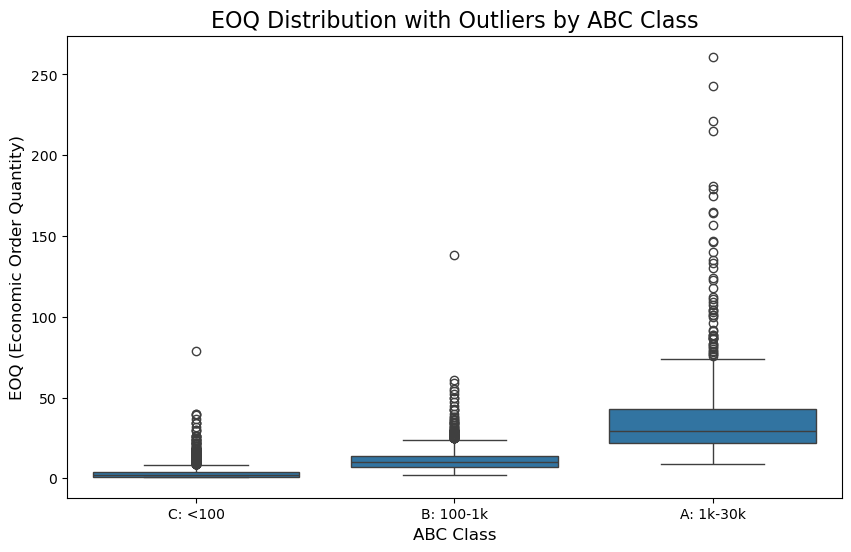

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=EOQ, x='ABC', y='EOQ')
plt.title('EOQ Distribution with Outliers by ABC Class', fontsize=16)
plt.xlabel('ABC Class', fontsize=12)
plt.ylabel('EOQ (Economic Order Quantity)', fontsize=12)
plt.show()


In [77]:

EOQ['EOQ'] = pd.to_numeric(EOQ['EOQ'], errors='coerce')  # Convert EOQ to numeric
EOQ['ABC'] = EOQ['ABC'].astype(str)  # Convert ABC_Class to string
print(EOQ.dtypes)

SalesQuantity      int64
CPO              float64
H                float64
EOQ                int64
Volume            object
ABC               object
dtype: object


## EOQ V/S Sales Quantity Analysis

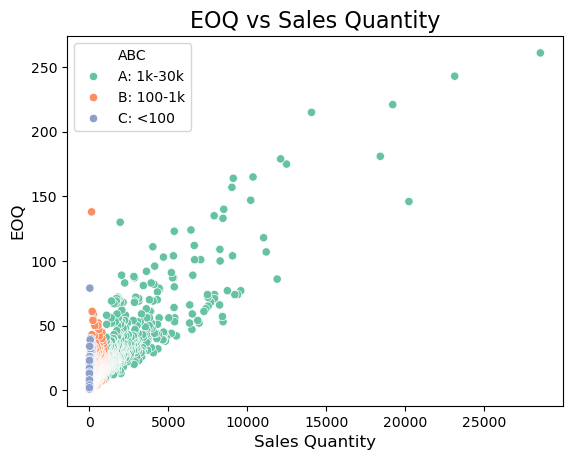

               SalesQuantity      EOQ
SalesQuantity        1.00000  0.87162
EOQ                  0.87162  1.00000


In [79]:
# Scatter plot
sns.scatterplot(data=EOQ, x='SalesQuantity', y='EOQ', hue='ABC', palette='Set2')
plt.title('EOQ vs Sales Quantity', fontsize=16)
plt.xlabel('Sales Quantity', fontsize=12)
plt.ylabel('EOQ', fontsize=12)
plt.show()

# Correlation
correlation = EOQ[['SalesQuantity', 'EOQ']].corr()
print(correlation)


## EOQ Volume Analysis


In [81]:
sales['Volume'].max()

20000

In [82]:
eoq_stats = EOQ.groupby('Volume')['EOQ'].agg(['mean', 'std', 'min', 'max', 'count']).reset_index()
print(eoq_stats)

   Volume       mean        std  min  max  count
0     100  20.625000  13.814459    1   36      8
1    1000   6.951673   8.825500    1   79    269
2     150   6.000000        NaN    6    6      1
3    1500  10.635294  10.344334    1   80    340
4    1750  18.444444  19.724677    1  147    342
5     180   3.250000   1.500000    2    5      4
6   18000   3.000000   1.732051    1    4      3
7     187   5.779412   8.147604    1   50     68
8     200  10.764706  22.634402    1   87     17
9     250   6.500000   2.516611    3    9      4
10    300   5.625000   4.910872    1   17     16
11   3000   7.582090   4.808922    1   19     67
12    330  24.666667  15.011107   10   40      3
13    375  10.968421  11.002119    1   56    190
14   4000   6.400000   4.857983    1   14     10
15     50  46.758242  49.332302    1  261    182
16    500   6.222222   5.806716    1   17     27
17   5000   9.600000   6.217622    1   22     35
18    650   1.000000        NaN    1    1      1
19    720   3.166667

ABC             A: 1k-30k  B: 100-1k   C: <100
VolumeCategory                                
Small           59.821918  12.929032  4.447489
Medium          30.569343  11.435440  3.181425
Large           35.210526  11.478803  3.639004


C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\2045312715.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



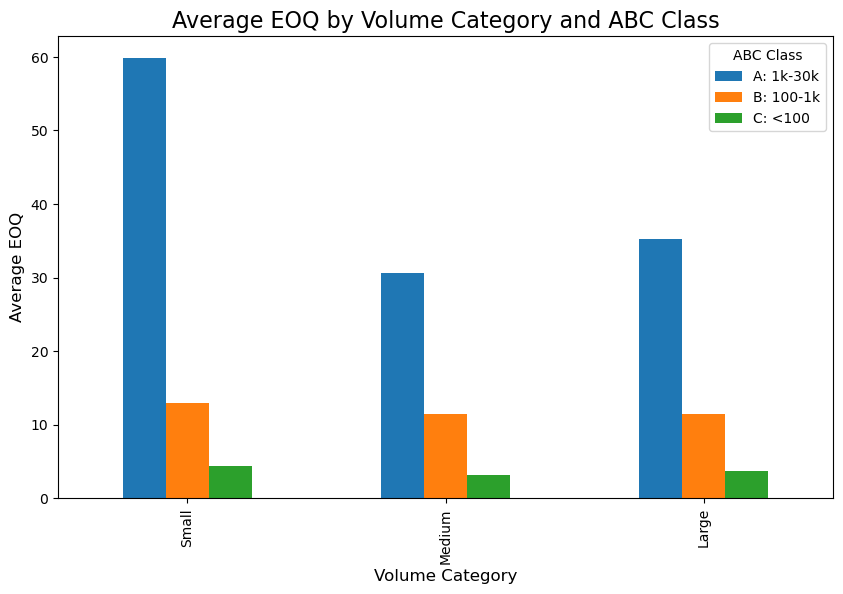

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called `EOQ`
# Convert 'Volume' to numeric (if it's not already)
EOQ['Volume'] = pd.to_numeric(EOQ['Volume'], errors='coerce')

# Define volume categories
EOQ['VolumeCategory'] = pd.cut(EOQ['Volume'], bins=[0, 500, 1000, 5000], labels=['Small', 'Medium', 'Large'])

# Group by volume category
volume_analysis = EOQ.groupby(['VolumeCategory', 'ABC'])['EOQ'].mean().unstack()

# Print the result
print(volume_analysis)

# Visualization
volume_analysis.plot(kind='bar', figsize=(10, 6))
plt.title('Average EOQ by Volume Category and ABC Class', fontsize=16)
plt.xlabel('Volume Category', fontsize=12)
plt.ylabel('Average EOQ', fontsize=12)
plt.legend(title='ABC Class')
plt.show()


## Freight and Holding Cost Efficiency

         ABC       CPO         H
0  A: 1k-30k  0.568221  2.411544
1  B: 100-1k  0.662665  3.405798
2    C: <100  1.270126  6.815074


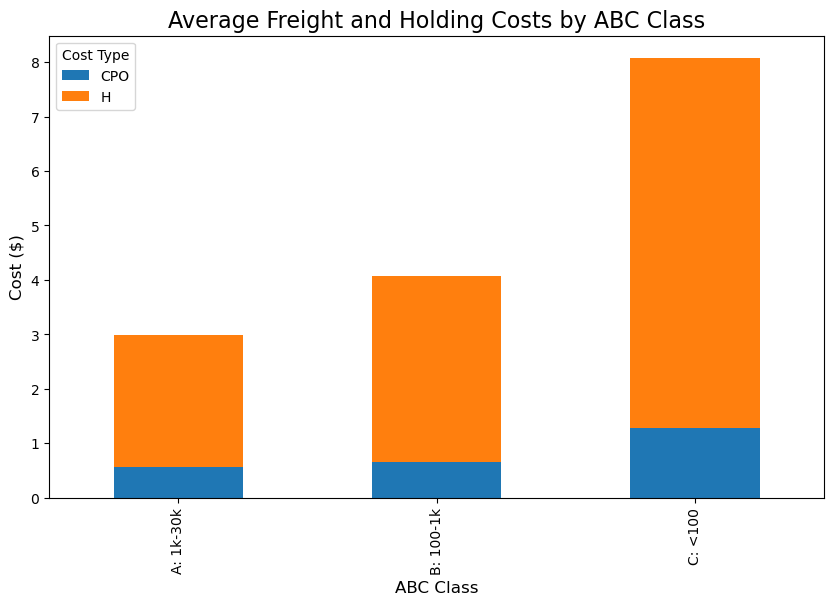

In [85]:
cost_analysis = EOQ.groupby('ABC')[['CPO', 'H']].mean().reset_index()
print(cost_analysis)

# Visualization
cost_analysis.plot(kind='bar', x='ABC', figsize=(10, 6), stacked=True)
plt.title('Average Freight and Holding Costs by ABC Class', fontsize=16)
plt.xlabel('ABC Class', fontsize=12)
plt.ylabel('Cost ($)', fontsize=12)
plt.legend(title='Cost Type')
plt.show()


 ## Stockout Risk Analysis


In [87]:
# * Average Daily Unit Sales
sales_velocity = (
    df_sorted.groupby(["Brand", "Description"]).agg({"SalesQuantity": "sum"}).reset_index()
)
days = (
    pd.to_datetime(sales["SalesDate"]).max() - pd.to_datetime(sales["SalesDate"]).min()
).days
sales_velocity["mean_daily_sales"] = sales_velocity["SalesQuantity"] / days
mean_daily_sales = sales_velocity.set_index("Brand")["mean_daily_sales"]
display(mean_daily_sales.to_frame().T, mean_daily_sales.describe().to_frame().T)

Brand                58        60       61        62        63        72     \
mean_daily_sales  4.881356  2.101695  0.40678  2.745763  2.220339  0.322034   

Brand                75         77        79        82     ...     90014  \
mean_daily_sales  0.050847  15.389831  7.050847  0.050847  ...  0.237288   

Brand               90025     90080     90081     90082     90084     90085  \
mean_daily_sales  0.20339  0.322034  0.118644  0.050847  0.033898  0.033898   

Brand                90086     90087     90089  
mean_daily_sales  0.016949  0.016949  0.457627  

[1 rows x 7658 columns]

count      mean        std       min       25%       50%  \
mean_daily_sales  7658.0  5.425077  17.203688  0.016949  0.169492  0.830508   

                       75%        max  
mean_daily_sales  4.033898  483.79661

In [88]:
max_sales_brand = df_sorted.groupby("Brand").agg({"SalesQuantity": "max"})
safety_stock = (
    max_sales_brand["SalesQuantity"]
    - sales_velocity.set_index("Brand")["mean_daily_sales"]
)
# Merge the safety stock values back into the df_sorted DataFrame
df_sorted = df_sorted.merge(
    safety_stock.rename("SafetyStock"),
    on="Brand",
    how="left"
)

# Display the first few rows to verify the changes
print(df_sorted.head())

          InventoryId  Store  Brand                   Description   Size  \
0   15_WANBORNE_42188     15  42188  Moet & Chandon Nectar Imp Rs  750mL   
1   69_MOUNTMEND_2753     69   2753    Johnnie Walker Black Label  1.75L   
2  73_DONCASTER_42188     73  42188  Moet & Chandon Nectar Imp Rs  750mL   
3   23_ARBINGTON_2492     23   2492  Crown Royal Hand Slct Barrel  750mL   
4    15_WANBORNE_2492     15   2492  Crown Royal Hand Slct Barrel  750mL   

   SalesQuantity  SalesDollars  SalesPrice  TotalSales  SalesDate  Volume  \
0            253      13279.97       52.49    13279.97 2016-02-06     750   
1            124       8678.76       69.99     8678.76 2016-01-29    1750   
2            151       8303.49       54.99     8303.49 2016-01-20     750   
3            131       7203.69       54.99     7203.69 2016-01-08     750   
4            129       7093.71       54.99     7093.71 2016-01-08     750   

   Classification  ExciseTax  VendorNo                   VendorName  \
0        

  ABC_Class  StockoutRisk
0         A      0.002541
1         B      0.002745
2         C      0.002359


C:\Users\sreey\AppData\Local\Temp\ipykernel_29400\3020000786.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




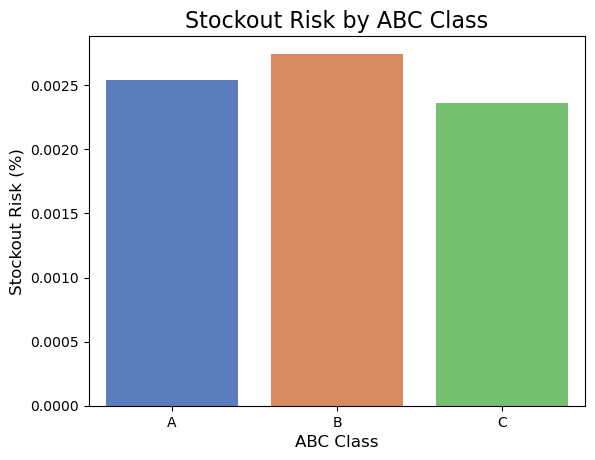

In [89]:
# Calculate stockout risk
df_sorted['StockoutRisk'] =df_sorted['EOQ'] < df_sorted['SafetyStock']  # SafetyStock column assumed to exist
stockout_risk_summary = df_sorted.groupby('ABC_Class')['StockoutRisk'].mean().reset_index()
print(stockout_risk_summary)

# Visualization
sns.barplot(data=stockout_risk_summary, x='ABC_Class', y='StockoutRisk', palette='muted')
plt.title('Stockout Risk by ABC Class', fontsize=16)
plt.xlabel('ABC Class', fontsize=12)
plt.ylabel('Stockout Risk (%)', fontsize=12)
plt.show()


The economic order quantity (EOQ) refers to the ideal order quantity a company should purchase in order to minimize its inventory costs, such as holding costs, shortage costs, and order costs. [[investopedia]](https://www.investopedia.com/ask/answers/052715/how-economic-order-quantity-model-used-inventory-management.asp). The economic order quantity model seeks to ensure that the right amount of inventory is ordered per batch.

Discussion:
- Freight cost depends on the volume of the liquor, which is why if the volume of the liquor is large then the cost per order is relatively large.
- Assume holding cost (%) is 30% of the PurchasePrice
- For the top demand brand number 8111, the EOQ is 261. Thus per batch (not per 2 month) the ideal order quantity for this brand is 261.
- Mean of EOQ is 8.9, with a count of 7146 brand, the total EOQ will be 635994

<span id='RPA'></span>

# Reorder Point

![Reorder Point Formula](https://www.inflowinventory.com/wp-content/uploads/2014/02/Reorder-Point-Formula-01-980x552.png)

In [92]:
# * Average Daily Unit Sales
sales_velocity = (
    sales.groupby(["Brand", "Description"]).agg({"SalesQuantity": "sum"}).reset_index()
)
days = (
    pd.to_datetime(sales["SalesDate"]).max() - pd.to_datetime(sales["SalesDate"]).min()
).days
sales_velocity["mean_daily_sales"] = sales_velocity["SalesQuantity"] / days
mean_daily_sales = sales_velocity.set_index("Brand")["mean_daily_sales"]
display(mean_daily_sales.to_frame().T, mean_daily_sales.describe().to_frame().T)

Brand                58        60       61        62        63        72     \
mean_daily_sales  4.881356  2.101695  0.40678  2.745763  2.220339  0.322034   

Brand                75         77        79        82     ...     90014  \
mean_daily_sales  0.050847  15.389831  7.050847  0.050847  ...  0.237288   

Brand               90025     90080     90081     90082     90084     90085  \
mean_daily_sales  0.20339  0.322034  0.118644  0.050847  0.033898  0.033898   

Brand                90086     90087     90089  
mean_daily_sales  0.016949  0.016949  0.457627  

[1 rows x 7658 columns]

count      mean        std       min       25%       50%  \
mean_daily_sales  7658.0  5.425077  17.203688  0.016949  0.169492  0.830508   

                       75%        max  
mean_daily_sales  4.033898  483.79661

In [93]:
# * Average Lead Time
purchase["lead_time"] = (
    pd.to_datetime(purchase["ReceivingDate"]) - pd.to_datetime(purchase["PODate"])
).dt.days
lead_time_brand = purchase.groupby("Brand").agg({"lead_time": "mean"})
display(lead_time_brand.T, lead_time_brand.describe().T)

Brand         58        60        61       62        63        70     \
lead_time  7.758389  7.659794  8.115385  7.33157  7.324427  7.333333   

Brand         72     75        77        79     ...  90080  90085  90086  \
lead_time  8.636364    7.0  7.292162  7.270161  ...   12.0    8.0    9.0   

Brand      90087  90088     90089  90090     90604      90609    90631  
lead_time    4.8    3.5  7.333333    4.5  7.384615  10.363636  9.21374  

[1 rows x 10664 columns]

count      mean       std  min       25%       50%       75%  \
lead_time  10664.0  7.818333  1.222754  3.0  7.277778  7.705882  8.294118   

            max  
lead_time  14.0

In [94]:
# * Safety Stock
max_sales_brand = sales.groupby("Brand").agg({"SalesQuantity": "max"})
safety_stock = (
    max_sales_brand["SalesQuantity"]
    - sales_velocity.set_index("Brand")["mean_daily_sales"]
)
display(safety_stock.to_frame().T, safety_stock.describe().to_frame().T)
# * notice there are negatives to fix this problem we will just set them to 0
safety_stock[safety_stock < 0] = 0

Brand     58        60        61        62        63        72        75     \
0      2.118644  0.898305  11.59322  0.254237  1.779661  2.677966  0.949153   

Brand     77        79        82     ...      90014    90025     90080  \
0     -7.389831 -2.050847  2.949153  ...  11.762712  9.79661  7.677966   

Brand     90081     90082     90084     90085     90086     90087      90089  
0      5.881356  1.949153  0.966102  1.966102  0.983051  0.983051  11.542373  

[1 rows x 7658 columns]

count     mean        std        min       25%       50%       75%  \
0  7658.0  6.12794  16.949081 -356.79661  1.508475  3.762712  9.525424   

          max  
0  407.966102

In [95]:

# * Reorder Point Analysis
RPA = (lead_time_brand['lead_time'] * mean_daily_sales) + safety_stock
RPA.name = "ReorderPoint"
RPA.dropna(inplace=True)
RPA = RPA.apply(lambda x: ceil(x)).to_frame()
RPA['ABC'] = ABC['bin']
display(RPA.T,RPA.describe().T)


Brand             58         60       61         62         63       72     \
ReorderPoint         40         17       15         21         19        6   
ABC           B: 100-1k  B: 100-1k  C: <100  B: 100-1k  B: 100-1k  C: <100   

Brand           75         77         79       82     ...    90010    90011  \
ReorderPoint        2        113         52        4  ...        3       14   
ABC           C: <100  B: 100-1k  B: 100-1k  C: <100  ...  C: <100  C: <100   

Brand           90012    90013    90014    90080    90085    90086    90087  \
ReorderPoint        8       15       14       12        3        2        2   
ABC           C: <100  C: <100  C: <100  C: <100  C: <100  C: <100  C: <100   

Brand           90089  
ReorderPoint       15  
ABC           C: <100  

[2 rows x 7146 columns]

count       mean         std  min  25%   50%   75%     max
ReorderPoint  7146.0  52.479429  136.521871  2.0  6.0  16.0  46.0  3687.0

### Visualize

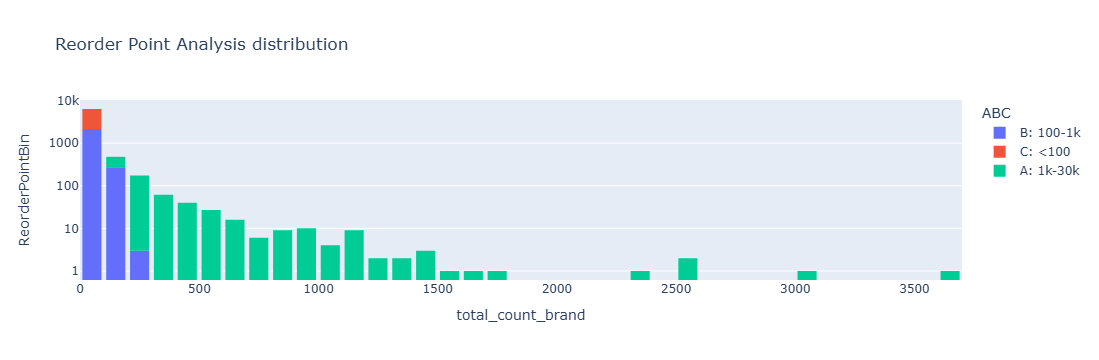

In [97]:
fig = px.histogram(
    RPA, x="ReorderPoint", color="ABC", nbins=50, title="Reorder Point Analysis distribution", log_y=True
)
fig.update_layout(
    bargap=0.2,
    xaxis_title_text="total_count_brand",  # xaxis label
    yaxis_title_text="ReorderPointBin",  # yaxis label
    
)
fig.show()

The reorder point (ROP) is the minimum stock level a specific product can reach before you’re prompted to order more inventory. A reorder point is not a static number. It’s based on your purchase and sales cycles, and it varies by product. [[inflow]](https://www.inflowinventory.com/blog/reorder-point-formula-safety-stock/) It is mainly used to avoid stockouts and avoid overstocking. It reduces the shipping cost and improve forecasting.

discussion:
- For this analysis we define safety stock as the maximum sales per day of a brand subtracted by average sales per day of a brand.
- As we can see from the Reorder Point Analysis Distribution, the majority of brand (6299 out of 7146) has a reorder point ranging between 0 to 99. Which consists of mostly the C level brands.
- There are a couple of outliers when the reorder points reach thousands of bottle of reorder point, mostly the A level brands which is our top gainers and top priority. This makes perfect sense since the velocity of sales is significantly higher than the C level making it more important to have large reorder point to avoid stockout. And the demand of A level is at a constant pace rather than C level which is only ordered once per month, so the products flow rather than stuck in the inventory.

<span id='LTA'></span>

# Lead Time Analysis


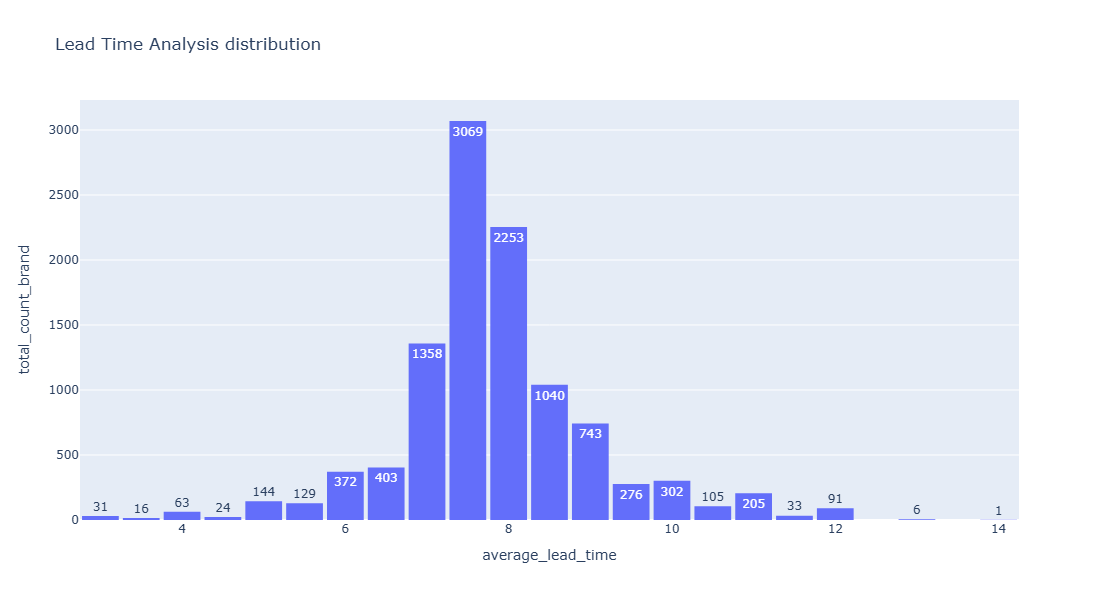

In [100]:
fig = px.histogram(lead_time_brand, x='lead_time', nbins=50, title="Lead Time Analysis distribution",text_auto=True)
fig.update_layout(
    bargap=0.1,
    xaxis_title_text="average_lead_time",  # xaxis label
    yaxis_title_text="total_count_brand",  # yaxis label
    height=600
)
fig.show()

Lead time is the amount of time that passes from the start of a process until its conclusion. [[investopedia]](https://www.investopedia.com/terms/l/leadtime.asp#toc-what-is-lead-time). In this case, the lead time is the shipping of liquor which is between submitting a purchase order and receiving the liquor. Lead time is important for production processes and inventory management.

Discussion:
- The distribution of average lead time shows a normal distribution, where a collective of brands have a mean lead time of 7.25-8.25 days.
- The lowest average lead time is around 2.75-3.25.
- With the majority of brands having a lead time more than a week, inventory management strategy needs to adapt to the situation. Ordering new batch needs to be done at least 1 or 2 week in advance in order to avoid inventory level hitting the safety stock or worse stockouts.

<span id='CCA'></span>

# Carrying Cost Analysis

- Inventory carrying cost is the total of all expenses related to storing unsold goods.
- The total includes intangibles like depreciation and lost opportunity cost as well as warehousing costs.
- A business' inventory carrying costs will generally total about 20% to 30% of its total inventory value. [[investopedia]](https://www.investopedia.com/terms/c/carryingcostofinventory.asp)

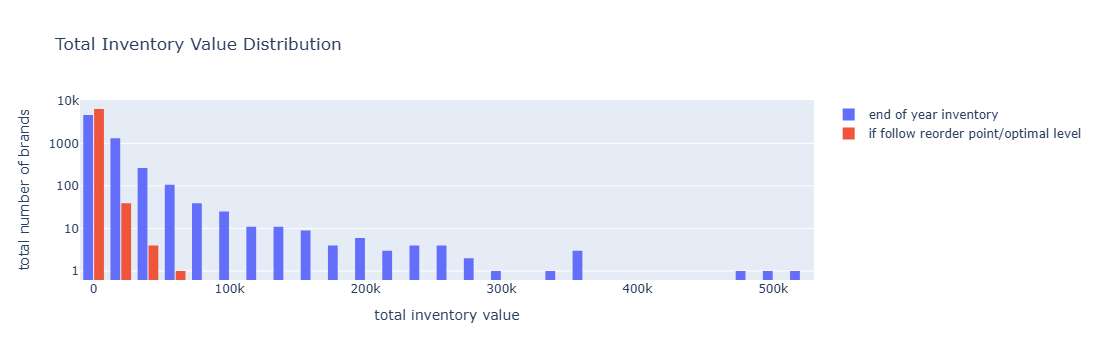

total_value total_value_if_RPA total_value_saved_if_RPA
0  $70,395,768         $5,076,401              $65,319,367

Price                 Description total_value  onHand     RPA  \
Brand                                                                  
1233   34.99     Jack Daniels No 7 Black    $526,495   15047  1209.0   
3545   29.99             Ketel One Vodka    $502,932   16770  1484.0   
2753   59.99  Johnnie Walker Black Label    $470,862    7849   236.0   
8068   23.49            Absolut 80 Proof    $366,632   15608  1413.0   
3405   28.99       Tito's Handmade Vodka    $355,649   12268  1179.0   
4261   20.99      Capt Morgan Spiced Rum    $351,981   16769  2518.0   
2757   28.99    Johnnie Walker Red Label    $336,371   11603   662.0   
2589   37.99       Jameson Irish Whiskey    $300,957    7922   640.0   
1376   20.99                    Jim Beam    $276,648   13180   916.0   
2585   25.99       Jameson Irish Whiskey    $272,557   10487   895.0   

      total_value_if_RPA total_value_saved_if_RPA  
Brand                                              
1233             $42,303                 $484,192  
3545             $44,505                 $458,427  
2753             $14,158                 $456,704  
8068             $33,191                 $333,441  
3405             $34,179                 $321,470  
4261             $52,853                 $299,128  
2757             $19,191                 $317,180  
2589             $24,314                 $276,643  
1376             $19,227                 $257,421  
2585             $23,261                 $249,296

Price                   Description total_value  onHand   RPA  \
Brand                                                                   
15729    2.49       Copa di Vino Pnt Grigio          $0       0  31.0   
12429   15.99  F Coppola Diamnd Petite Sira          $0       0   8.0   
19347   11.99        The Royal Chenin Blanc          $0       0   2.0   
3058     0.99            Three Olives Vodka          $0       0  15.0   
42797   18.49  Ricardo Santos Malbec Mendza          $0       0  29.0   
25201   18.99  Ch Croix de Jaugue St Emilio          $0       0  21.0   
45993   10.99      Casa Liliana Good Merlot          $0       0   3.0   
2943   119.99        The Macallan 18 Yr Old          $0       0   2.0   
24975   17.99                 Tenshen White          $0       0  25.0   
19754   10.99     BV Coastal Estate Moscato          $0       0   2.0   

      total_value_if_RPA total_value_saved_if_RPA  
Brand                                              
15729                $77                     $-77  
12429               $128                    $-128  
19347                $24                     $-24  
3058                 $15                     $-15  
42797               $536                    $-536  
25201               $399                    $-399  
45993                $33                     $-33  
2943                $240                    $-240  
24975               $450                    $-450  
19754                $22                     $-22

In [103]:
import plotly.graph_objects as go

annual_inventory_value = end_inv.copy()
annual_inventory_value["total_value"] = (
    annual_inventory_value["onHand"] * annual_inventory_value["Price"]
)
brand_inventory_value = annual_inventory_value.groupby("Brand").agg(
    {"Price": "first", "Description": "first", "total_value": "sum", "onHand": "sum"}
)

brand_inventory_value.sort_values("total_value", ascending=False, inplace=True)
brand_inventory_value["RPA"] = RPA["ReorderPoint"]
brand_inventory_value["total_value_if_RPA"] = (
    brand_inventory_value["RPA"] * brand_inventory_value["Price"]
)
brand_inventory_value["total_value_saved_if_RPA"] = (
    brand_inventory_value["total_value"] - brand_inventory_value["total_value_if_RPA"]
)
brand_inventory_value.dropna(inplace=True)

fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=brand_inventory_value["total_value"],
        name="end of year inventory",
        nbinsx=50,
    )
)
fig.add_trace(
    go.Histogram(
        x=brand_inventory_value["total_value_if_RPA"],
        name="if follow reorder point/optimal level",
        nbinsx=50,
    )
)
fig.update_yaxes(type="log")
fig.update_layout(
    title_text="Total Inventory Value Distribution",
    xaxis_title_text="total inventory value",  # xaxis label
    yaxis_title_text="total number of brands",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)

fig.show()

display(brand_inventory_value[['total_value','total_value_if_RPA','total_value_saved_if_RPA']].sum().apply(lambda x: f"${x:,.0f}").to_frame().T)
brand_inventory_value["total_value"] = brand_inventory_value["total_value"].apply(
    lambda x: f"${x:,.0f}"
)
brand_inventory_value["total_value_if_RPA"] = brand_inventory_value[
    "total_value_if_RPA"
].apply(lambda x: f"${x:,.0f}")
brand_inventory_value["total_value_saved_if_RPA"] = brand_inventory_value[
    "total_value_saved_if_RPA"
].apply(lambda x: f"${x:,.0f}")
display(brand_inventory_value.head(10), brand_inventory_value.tail(10))

Discussion:
- The total inventory value of the company at the end of the year resulted to $79 mio.
- The top 10 product based on total inventory value has a total inventory value ranging between $526k to $272k
- Keep in mind the reorder points are calculated with only 2 months of sales data, we have no way of telling whether after february the sales goes up (which makes the reorder point up) or down (makes the reorder point goes down). This causes a huge difference in total inventory value at the end of the year and the reorder point (2 months of sales data).
- The total amount of inventory value if we respect the reorder point model is around $5 mio which saves around $65 mio. For the top 10 total inventory value brands, it saves around $250 k - $500 k of inventory value. If the carrying cost is around 20-25% of the inventory value then it would save around $50 k - $100 k.
- Observing some of the brands that are out of stock at the end of the year, the reorder point suggest that they need to be restocked to the optimal value. This allows the company to have optimal inventory level so that when order comes they can still sell the products, and even if brands become dead stock it will still minimize carrying cost or when it comes to throwing old stocks reduce the amount of loss.